---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [3]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [6]:
# Task 2a: Load the data

# We override the default path by passing data_dir="data"
# This tells it to look in the 'data' folder in the CURRENT directory
products = load_wands_products(data_dir="data")
queries = load_wands_queries(data_dir="data")
labels = load_wands_labels(data_dir="data")

# Print the number of rows in each dataset
print(f"Products loaded: {len(products)}")
print(f"Queries loaded: {len(queries)}")
print(f"Labels loaded: {len(labels)}")

Products loaded: 42994
Queries loaded: 480
Labels loaded: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [8]:
# YOUR CODE HERE
import pandas as pd

# Load the datasets with tab separator
products = pd.read_csv('data/wayfair-products.csv', sep='\t')
queries = pd.read_csv('data/wayfair-queries.csv', sep='\t')
labels = pd.read_csv('data/wayfair-labels.csv', sep='\t')

# Function to display info for each file
def explore_file(df, name):
    print(f"\n--- {name} ---")
    print(f"Columns: {list(df.columns)}")
    print(f"Shape: {df.shape}")
    display(df.head(2))

explore_file(products, "Products")
explore_file(queries, "Queries")
explore_file(labels, "Labels")


--- Products ---
Columns: ['product_id', 'product_name', 'product_class', 'category hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']
Shape: (42994, 9)


,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0



--- Queries ---
Columns: ['query_id', 'query', 'query_class']
Shape: (480, 3)


,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables



--- Labels ---
Columns: ['id', 'query_id', 'product_id', 'label']
Shape: (233448, 4)


,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [9]:
# Task 2c: Understand judgments

# 1. Map text labels to numeric grades (if not already done)
grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
labels['grade'] = labels['label'].map(grade_map)

# 2. Calculate the counts
grade_counts = labels['grade'].value_counts().sort_index()
label_counts = labels['label'].value_counts()

# 3. Print the results
print("--- Distribution of Grades (0=Irrelevant, 1=Partial, 2=Exact) ---")
print(grade_counts)

print("\n--- Distribution of Labels ---")
print(label_counts)

print("\n--- Percentage Distribution ---")
print(labels['label'].value_counts(normalize=True).mul(100).round(2))

--- Distribution of Grades (0=Irrelevant, 1=Partial, 2=Exact) ---
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64

--- Distribution of Labels ---
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64

--- Percentage Distribution ---
label
Partial       62.81
Irrelevant    26.22
Exact         10.97
Name: proportion, dtype: float64


In [10]:
# Inspect examples for a specific query

# 1. Merge the dataframes so we can see the text
# Merge labels with queries to get the query text
df_merged = labels.merge(queries, on='query_id')
# Merge with products to get product details
df_merged = df_merged.merge(products, on='product_id')

# 2. Pick a specific query to investigate
# Query ID 0 is "salon chair"
sample_query_id = 0 

# Filter for this query
query_data = df_merged[df_merged['query_id'] == sample_query_id]
query_text = query_data['query'].iloc[0]

print(f"--- Search Query: '{query_text}' (ID: {sample_query_id}) ---")

# 3. Show examples of each relevance grade
# We manually define the descriptions here to make the output readable
grade_descriptions = {
    2: "Exact (Perfect Match)",
    1: "Partial (Relevant but not perfect)",
    0: "Irrelevant (Not what the user wanted)"
}

for grade in [2, 1, 0]:
    print(f"\n--- {grade_descriptions[grade]} ---")
    
    # Get rows with this grade
    examples = query_data[query_data['grade'] == grade]
    
    if len(examples) > 0:
        # Show the top 2 examples
        for _, row in examples.head(2).iterrows():
            print(f"Product: {row['product_name']}")
            # Print just the first 100 characters of the description
            print(f"Desc: {row['product_description'][:100]}...")
            print("-" * 30)
    else:
        print("No examples found for this grade.")

--- Search Query: 'salon chair' (ID: 0) ---

--- Exact (Perfect Match) ---
Product: 21.7 '' w waiting room chair with wood frame
Desc: this is a salon chair , barber chair for a hairstylist . it is cheap , classic , hydraulic pump spa ...
------------------------------
Product: 24.4 '' w metal lounge chair with metal frame
Desc: the heavy duty barber chair is built to last . it offers comfort as well as style every barber desir...
------------------------------

--- Partial (Relevant but not perfect) ---
Product: aliandra fashion casual lift chair office work beauty salon task chair
Desc: applicable scene : office , home life , beauty salons , etc . it is a new product with absolutely no...
------------------------------
Product: almuth fashion office beauty salon task chair
Desc: 100 % brand new and high quality . applicable scene : office , home life , beauty salons , etc . it ...
------------------------------

--- Irrelevant (Not what the user wanted) ---
Product: 22.5 '' wide poly

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [11]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [12]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [14]:
# Task 3a: Create BM25 index for product_name

# 1. Prepare the corpus
# We convert the product names to a list of strings
print("Building index..")
corpus = products['product_name'].fillna("").tolist()

# 2. Build the index
# We pass our corpus and our tokenizer function
name_index, name_doc_lengths = build_index(corpus, snowball_tokenize)

print(f"Index built successfully!")
print(f"Number of documents: {len(name_doc_lengths)}")
print(f"Number of unique terms: {len(name_index)}")

# 3. Run a sample search
sample_query = "salon chair"
print(f"\n--- Searching for '{sample_query}' ---")

results = search_products(
    query=sample_query, 
    products_df=products, 
    index=name_index, 
    doc_lengths=name_doc_lengths, 
    tokenizer=snowball_tokenize, 
    k=5
)

# Display the top 5 results
display(results[['product_name', 'score', 'rank']])

Building index..
Index built successfully!
Number of documents: 42994
Number of unique terms: 25570

--- Searching for 'salon chair' ---


,product_name,score,rank
7465,hair salon chair,11.477702,1
9234,beauty salon task chair,10.623625,2
25431,barberpub salon massage chair,10.623625,3
24010,bar salon task chair,10.623625,4
27443,beauty salon ergonomic task chair,9.887851,5


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [16]:
# Task 3b: Add product_description to search

# 1. Build the description index
print("Building description index..")
desc_corpus = products['product_description'].fillna("").tolist()
desc_index, desc_doc_lengths = build_index(desc_corpus, snowball_tokenize)

print(f"Description index built! Unique terms: {len(desc_index)}")

# 2. Define the dual-field search function
def search_dual_field(query: str, products_df: pd.DataFrame, 
                      name_idx: dict, name_lens: list,
                      desc_idx: dict, desc_lens: list,
                      tokenizer, k: int = 10):
    
    num_docs = len(products_df)
    
    # Get scores from the Name index
    scores_name = score_bm25(query, name_idx, num_docs, name_lens, tokenizer)
    
    # Get scores from the Description index
    scores_desc = score_bm25(query, desc_idx, num_docs, desc_lens, tokenizer)
    
    # Combine scores by adding them
    total_scores = scores_name + scores_desc
    
    # Get top K results
    top_k_idx = np.argsort(-total_scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = total_scores[top_k_idx]
    results['name_score'] = scores_name[top_k_idx]
    results['desc_score'] = scores_desc[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

# 3. Run the search
sample_query = "salon chair"
print(f"\n--- Dual-Field Search Results for '{sample_query}' ---")
results_dual = search_dual_field(
    sample_query, products, 
    name_index, name_doc_lengths, 
    desc_index, desc_doc_lengths, 
    snowball_tokenize
)

display(results_dual[['product_name', 'score', 'name_score', 'desc_score']])

Building description index..
Description index built! Unique terms: 20386

--- Dual-Field Search Results for 'salon chair' ---


,product_name,score,name_score,desc_score
7465,hair salon chair,26.231623,11.477702,14.753921
7468,mercer41 hair salon chair hydraulic styling ch...,23.166290,8.709853,14.456437
25431,barberpub salon massage chair,22.609648,10.623625,11.986024
25432,barberpub hydraulic salon spa reclining massag...,19.728855,7.742831,11.986024
15612,massage chair,19.472949,3.583769,15.889180
39461,professional salon reclining massage chair,19.080945,9.887851,9.193094
39428,barber salon reclining massage chair,18.252872,9.887851,8.365021
22130,height-adjustable stool salon chair,17.856536,9.887851,7.968685
7466,reclining massage chair,17.793086,3.295655,14.497431
42929,all purpose hydraulic salon barber massage chair,17.664209,8.684855,8.979353


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [ ]:
# Task 4a: Answer in a comment

# Why does DCG use log2 for the discount? 
 """The log2 function is used to model the "decay" of user attention. 
 It penalizes results that appear lower in the ranking because users are less 
likely to see or click them. The curve is logarithmic because attention doesn't 
drop to zero immediately, but the "value" of a position diminishes significantly 
after the first few slots."""

# What's the effect on position 1 vs position 10?
"""- At Position 1: The denominator is log2(1 + 1) = 1. 
   There is NO discount. The result contributes 100% of its relevance score.
   
 - At Position 10: The denominator is log2(10 + 1) ≈ 3.46.
   The result's score is divided by ~3.5. This means a relevant item at position 10 
   is worth less than one-third of what it would be worth at position 1."""

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [20]:
# Task 4b: Calculate NDCG by hand

# Task 4b: Calculate NDCG by hand
import numpy as np

# 1. Define the relevance scores for our ranking
# Ranking: Partial(1), Exact(2), Partial(1), Irrelevant(0), Exact(2)
relevance_scores = [1, 2, 1, 0, 2]

def calculate_dcg(scores):
    """Calculate Discounted Cumulative Gain"""
    dcg = 0
    for i, rel in enumerate(scores):
        position = i + 1
        # Formula: (2^rel - 1) / log2(position + 1)
        gain = (2**rel - 1) / np.log2(position + 1)
        dcg += gain
    return dcg

# 2. Calculate Actual DCG
actual_dcg = calculate_dcg(relevance_scores)
print(f"Actual DCG: {actual_dcg:.4f}")

# 3. Calculate Ideal DCG (IDCG)
# Ideal ranking is the scores sorted descending
ideal_scores = sorted(relevance_scores, reverse=True)
ideal_dcg = calculate_dcg(ideal_scores)
print(f"Ideal DCG:  {ideal_dcg:.4f}")

# 4. Calculate NDCG
ndcg = actual_dcg / ideal_dcg
print(f"NDCG@5:     {ndcg:.4f}")

Actual DCG: 4.5533
Ideal DCG:  5.8235
NDCG@5:     0.7819


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [23]:
# Task 4c: Implement NDCG function
import numpy as np

def calculate_dcg(scores: list[int], k: int = None) -> float:
    """
    Calculate DCG@k.
    Formula: sum((2^rel - 1) / log2(i + 1))
    """
    # If k is not provided, use the full list
    if k is None:
        k = len(scores)
        
    # Slice the scores to consider only top k
    current_scores = scores[:k]
    
    dcg = 0.0
    for i, rel in enumerate(current_scores):
        position = i + 1
        gain = (2**rel - 1) / np.log2(position + 1)
        dcg += gain
        
    return dcg

def calculate_ndcg(scores: list[int], k: int = 5) -> float:
    """
    Calculate NDCG@k.
    """
    # 1. Calculate Actual DCG
    actual_dcg = calculate_dcg(scores, k)
    
    # 2. Calculate Ideal DCG
    # Sort scores descending to get the ideal ranking
    ideal_scores = sorted(scores, reverse=True)
    ideal_dcg = calculate_dcg(ideal_scores, k)
    
    # 3. Handle division by zero
    if ideal_dcg == 0:
        return 0.0
        
    return actual_dcg / ideal_dcg

# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

DCG@5 = 4.5533
NDCG@5 = 0.7819


In [24]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [25]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [26]:
# Task 5a: Run evaluation on all queries

# 1. Define a search function that fits the evaluate interface
# We wrap our search_products function to use the name_index we built earlier
def search_bm25_name(query_text):
    return search_products(
        query=query_text,
        products_df=products,
        index=name_index,          # Using the index from Task 3a
        doc_lengths=name_doc_lengths,
        tokenizer=snowball_tokenize,
        k=10
    )

# 2. Run the evaluation
print("Evaluating BM25 on Product Name...")
results_name = evaluate_search(
    search_func=search_bm25_name,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10
)

# 3. Check the results
print("\n--- Evaluation Results ---")
print(f"Mean NDCG@10: {results_name['ndcg'].mean():.4f}")

# Optional: Look at the distribution of scores
print("\n--- detailed stats ---")
print(results_name['ndcg'].describe())

Evaluating BM25 on Product Name...
Evaluated 480 queries
Mean NDCG@10: 0.8660

--- Evaluation Results ---
Mean NDCG@10: 0.8660

--- detailed stats ---
count    480.000000
mean       0.865955
std        0.239757
min        0.000000
25%        0.825292
50%        0.981670
75%        1.000000
max        1.000000
Name: ndcg, dtype: float64


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [ ]:
# Task 5b: Identify failing queries

# 1. Filter for queries with poor performance (NDCG < 0.1)
failing_queries = results_name[results_name['ndcg'] < 0.1].sort_values('ndcg')

print(f"Found {len(failing_queries)} failing queries.")
print("\n--- Top 5 Failing Queries ---")
display(failing_queries.head(5))

# 2. Analyze a specific failure
target_query_id = 29
target_query_text = "bathroom vanity knobs"

print(f"\n--- Deep Dive: '{target_query_text}' ---")

# A. What did our search return?
print("\n>>> Top Results from our Search:")
my_results = search_bm25_name(target_query_text)
display(my_results[['product_name', 'score']].head(3))

# B. What SHOULD it have returned? (Ground Truth)
print("\n>>> Correct 'Exact' Matches (from labels):")
# Get product IDs labeled as Exact (2) for this query
relevant_ids = labels[
    (labels['query_id'] == target_query_id) & 
    (labels['grade'] == 2)
]['product_id']

relevant_products = products[products['product_id'].isin(relevant_ids)]
display(relevant_products[['product_name', 'product_description']].head(3))



Found 24 failing queries.

--- Top 5 Failing Queries ---


,query_id,query,ndcg
29,29,bathroom vanity knobs,0.0
33,33,non slip shower floor tile,0.0
58,58,medium size chandelier,0.0
79,79,palram harmony greenhouses,0.0
173,174,star wars rug,0.0



--- Deep Dive: 'bathroom vanity knobs' ---

>>> Top Results from our Search:


,product_name,score
20628,bathroom/vanity mirror,9.240025
7,36 '' single bathroom vanity,8.552457
4407,30 '' single bathroom vanity,8.552457



>>> Correct 'Exact' Matches (from labels):


,product_name,product_description
1623,radiance 1 3/16 '' diameter mushroom knob,the radiance vivacité round knob is by far the...
4005,ingot 1 1/16 '' length square knob,meshing modern geometric forms with the raw in...
7874,1 '' diameter round knob,the simplicity of its circular shape means tha...


Analysis of the Failure

Search Results: Products like "Bathroom/Vanity Mirror".

Actual Intent: The user wanted Knobs (hardware), but the search engine latched onto the words "Bathroom" and "Vanity" and found mirrors because they appeared more frequently or had higher scores in the index, ignoring the crucial word "Knobs" or ranking it lower.

The Issue: This is a "term mismatch" or "query understanding" problem. The search engine doesn't know that "Knob" is the core object and "Bathroom Vanity" is just a modifier.

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

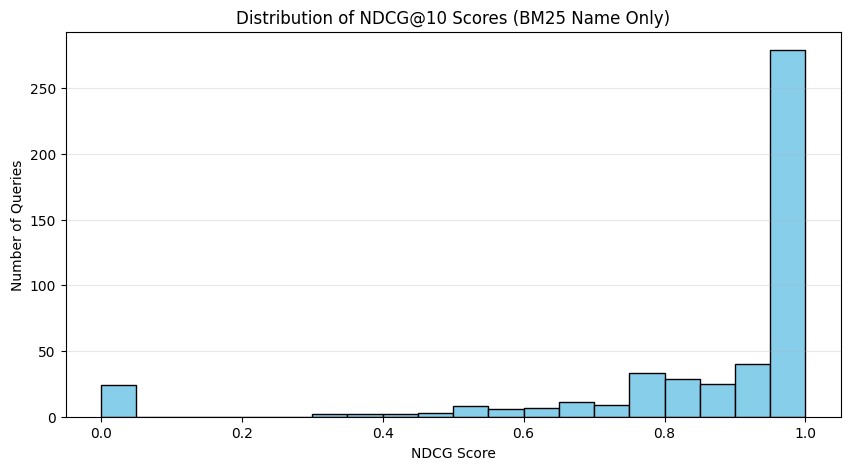

Total Queries: 480
Queries with 0.0 NDCG: 24 (5.0%)
Queries with 1.0 NDCG: 197 (41.0%)


In [28]:
# Task 5c: Analyze the distribution
import matplotlib.pyplot as plt

# 1. Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(results_name['ndcg'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NDCG@10 Scores (BM25 Name Only)')
plt.xlabel('NDCG Score')
plt.ylabel('Number of Queries')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Print key statistics
zeros = (results_name['ndcg'] == 0).sum()
perfect = (results_name['ndcg'] == 1.0).sum()
total = len(results_name)

print(f"Total Queries: {total}")
print(f"Queries with 0.0 NDCG: {zeros} ({zeros/total*100:.1f}%)")
print(f"Queries with 1.0 NDCG: {perfect} ({perfect/total*100:.1f}%)")

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [29]:
# Task 6a: Index product_class field

# 1. Build the Product Class index
print("Building product_class index...")
class_corpus = products['product_class'].fillna("").tolist()
class_index, class_doc_lengths = build_index(class_corpus, snowball_tokenize)

print(f"Class index built! Unique terms: {len(class_index)}")

# 2. Define the 3-field search function
def search_tri_field(query: str, products_df: pd.DataFrame, 
                     name_idx: dict, name_lens: list,
                     desc_idx: dict, desc_lens: list,
                     class_idx: dict, class_lens: list,
                     tokenizer, k: int = 10):
    
    num_docs = len(products_df)
    
    # Calculate scores for all three fields
    scores_name = score_bm25(query, name_idx, num_docs, name_lens, tokenizer)
    scores_desc = score_bm25(query, desc_idx, num_docs, desc_lens, tokenizer)
    scores_class = score_bm25(query, class_idx, num_docs, class_lens, tokenizer)
    
    # Combine scores (Simple Sum)
    # You can add weights here later! e.g., 3*name + 1*desc + 2*class
    total_scores = scores_name + scores_desc + scores_class
    
    # Get Top K
    top_k_idx = np.argsort(-total_scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = total_scores[top_k_idx]
    results['name_score'] = scores_name[top_k_idx]
    results['desc_score'] = scores_desc[top_k_idx]
    results['class_score'] = scores_class[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

# 3. Test it out
sample_query = "salon chair"
results_tri = search_tri_field(
    sample_query, products,
    name_index, name_doc_lengths,
    desc_index, desc_doc_lengths,
    class_index, class_doc_lengths,
    snowball_tokenize
)

print(f"\n--- Tri-Field Search Results for '{sample_query}' ---")
display(results_tri[['product_name', 'product_class', 'score', 'class_score']].head())

Building product_class index...
Class index built! Unique terms: 628

--- Tri-Field Search Results for 'salon chair' ---


,product_name,product_class,score,class_score
7465,hair salon chair,Massage Chairs|Recliners,28.499253,2.267631
7468,mercer41 hair salon chair hydraulic styling ch...,Massage Chairs,25.871746,2.705457
25431,barberpub salon massage chair,Massage Chairs,25.315105,2.705457
15612,massage chair,Massage Chairs,22.178405,2.705457
25432,barberpub hydraulic salon spa reclining massag...,Massage Chairs|Recliners,21.996485,2.267631


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [30]:
# Task 6b: Evaluate three-field search

# 1. Define the wrapper function
# This helps the evaluate_search function call our complex 3-field search
def search_bm25_tri(query_text):
    return search_tri_field(
        query=query_text,
        products_df=products,
        name_idx=name_index, name_lens=name_doc_lengths,
        desc_idx=desc_index, desc_lens=desc_doc_lengths,
        class_idx=class_index, class_lens=class_doc_lengths,
        tokenizer=snowball_tokenize,
        k=10
    )

# 2. Run the evaluation
print("Evaluating Tri-Field Search (Name + Description + Class)...")
results_tri = evaluate_search(
    search_func=search_bm25_tri,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10
)

# 3. Compare Results
print("\n--- Improvement Analysis ---")
mean_ndcg = results_tri['ndcg'].mean()
print(f"New Mean NDCG@10: {mean_ndcg:.4f}")

# Check the failing query from before (ID 29: bathroom vanity knobs)
print("\n--- Re-checking 'bathroom vanity knobs' ---")
q29_res = search_bm25_tri("bathroom vanity knobs")
display(q29_res[['product_name', 'product_class', 'score']].head(3))

Evaluating Tri-Field Search (Name + Description + Class)...
Evaluated 480 queries
Mean NDCG@10: 0.8791

--- Improvement Analysis ---
New Mean NDCG@10: 0.8791

--- Re-checking 'bathroom vanity knobs' ---


,product_name,product_class,score
22220,damask™ mushroom knob,Cabinet and Drawer Knobs,26.576078
16417,deco 1/4 '' length square knob,Cabinet and Drawer Knobs,26.225126
16413,deco 1 1/4 '' length square knob,Cabinet and Drawer Knobs,25.882379


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [31]:
# Task 6c: Compare to baseline

# 1. Merge the two results dataframes on query_id
# We use suffixes to distinguish between the two runs
comparison = pd.merge(
    results_name, 
    results_tri, 
    on=['query_id', 'query'], 
    suffixes=('_name', '_tri')
)

# 2. Calculate the difference (Positive = Improvement)
comparison['improvement'] = comparison['ndcg_tri'] - comparison['ndcg_name']

# 3. Print Summary Stats
print(f"Total Queries: {len(comparison)}")
print(f"Improved: {(comparison['improvement'] > 0).sum()}")
print(f"Degraded: {(comparison['improvement'] < 0).sum()}")
print(f"Same:     {(comparison['improvement'] == 0).sum()}")

# 4. Show the biggest winners
print("\n--- Top 5 Improvements ---")
display(comparison.sort_values('improvement', ascending=False).head(5))

# 5. Show the biggest losers
print("\n--- Top 5 Degradations ---")
display(comparison.sort_values('improvement', ascending=True).head(5))

Total Queries: 480
Improved: 177
Degraded: 158
Same:     145

--- Top 5 Improvements ---


,query_id,query,ndcg_name,ndcg_tri,improvement
29,29,bathroom vanity knobs,0.0,1.000000,1.000000
340,345,oriental vanity,0.0,0.997188,0.997188
280,284,family lamp,0.0,0.901118,0.901118
33,33,non slip shower floor tile,0.0,0.825637,0.825637
58,58,medium size chandelier,0.0,0.716408,0.716408



--- Top 5 Degradations ---


,query_id,query,ndcg_name,ndcg_tri,improvement
446,453,midcentury tv unit,1.000000,0.000000,-1.000000
45,45,70s inspired furniture,0.799669,0.000000,-0.799669
147,147,drum picture,0.979019,0.289065,-0.689954
403,409,teal chair,1.000000,0.471628,-0.528372
445,452,day bed indian,1.000000,0.500000,-0.500000


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [33]:
# Task 7a: Extract product type, theme, material, color
import os
from pydantic import BaseModel, Field
from typing import Optional
import litellm
import json

# 1. Define the structure we want
class SearchQuery(BaseModel):
    product_type: str = Field(..., description="The core product being searched for (e.g., 'rug', 'chair')")
    theme: Optional[str] = Field(None, description="The theme or style (e.g., 'Star Wars', 'Modern', 'Boho')")
    material: Optional[str] = Field(None, description="Material (e.g., 'wool', 'metal', 'leather')")
    color: Optional[str] = Field(None, description="Color (e.g., 'red', 'navy blue')")
    dimensions: Optional[str] = Field(None, description="Size or dimensions (e.g., '5x7', 'small')")
    intended_room: Optional[str] = Field(None, description="Room this is for (e.g., 'bathroom', 'living room')")

# 2. Define the extraction function
def extract_query_info(query: str, model_name: str = "gpt-4o") -> SearchQuery:
    """
    Uses an LLM to extract structured attributes from a search query.
    """
    try:
        response = litellm.completion(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful e-commerce search assistant. Extract key attributes from the user's search query into JSON."},
                {"role": "user", "content": f"Query: {query}"}
            ],
            response_format=SearchQuery
        )
        
        # Parse the result
        content = response.choices[0].message.content
        return SearchQuery.model_validate_json(content)
        
    except Exception as e:
        print(f"Error processing query '{query}': {e}")
        # Return empty object on failure
        return SearchQuery(product_type=query)

# 3. Test it
example_query = "star wars rug 5x7"
extracted = extract_query_info(example_query)
print(f"Query: {example_query}")
print(extracted.model_dump_json(indent=2))

Query: star wars rug 5x7
{
  "product_type": "rug",
  "theme": "Star Wars",
  "material": null,
  "color": null,
  "dimensions": "5x7",
  "intended_room": null
}


In [35]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    print(f"--- Query: '{q}' ---")
    
    # Call the function we defined in Task 7a
    extracted_info = extract_query_info(q)
    
    # Print the structured output nicely
    print(extracted_info.model_dump_json(indent=2))
    print("\n")

--- Query: 'star wars rug' ---
{
  "product_type": "rug",
  "theme": "Star Wars",
  "material": null,
  "color": null,
  "dimensions": null,
  "intended_room": null
}


--- Query: 'wooden coffee table' ---
{
  "product_type": "coffee table",
  "theme": null,
  "material": "wooden",
  "color": null,
  "dimensions": null,
  "intended_room": null
}


--- Query: 'blue leather sofa' ---
{
  "product_type": "sofa",
  "theme": null,
  "material": "leather",
  "color": "blue",
  "dimensions": null,
  "intended_room": null
}


--- Query: 'modern metal bookshelf' ---
{
  "product_type": "bookshelf",
  "theme": "modern",
  "material": "metal",
  "color": null,
  "dimensions": null,
  "intended_room": null
}




### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [36]:
# Task 7b: Create an LLM-enhanced search

def search_llm_boost(query: str, products_df: pd.DataFrame, 
                     name_idx: dict, name_lens: list,
                     desc_idx: dict, desc_lens: list,
                     class_idx: dict, class_lens: list,
                     tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search with LLM-based boosting.
    1. Extract product type using LLM.
    2. Calculate base BM25 scores (Tri-Field).
    3. Add a scalar boost to items matching the product type.
    """
    
    # 1. Extract Query Info
    # (We wrap this in a try/except in case the API call fails)
    try:
        info = extract_query_info(query)
        target_type = info.product_type
        print(f"LLM inferred intent: '{target_type}'")
    except Exception as e:
        print(f"LLM extraction skipped: {e}")
        target_type = None
        
    num_docs = len(products_df)
    
    # 2. Calculate Base Scores (Tri-Field BM25)
    # We calculate scores for ALL documents so we can boost the relevant ones
    # even if they were originally low-ranked.
    s_name = score_bm25(query, name_idx, num_docs, name_lens, tokenizer)
    s_desc = score_bm25(query, desc_idx, num_docs, desc_lens, tokenizer)
    s_class = score_bm25(query, class_idx, num_docs, class_lens, tokenizer)
    
    total_scores = s_name + s_desc + s_class
    
    # 3. Apply LLM Boost
    if target_type:
        # Find products where the class contains the target type (case-insensitive)
        # e.g. target="rug" matches class="Area Rugs"
        matches_type = products_df['product_class'].astype(str).str.lower().str.contains(target_type.lower())
        
        match_count = matches_type.sum()
        
        if match_count > 0:
            # BOOST: Add points to the matching products.
            # +10 is a strong signal (equivalent to several keyword matches)
            boost_amount = 10.0
            total_scores[matches_type] += boost_amount
            print(f"--> Boosted {match_count} products by +{boost_amount} points.")
        else:
            print(f"--> No products matched class '{target_type}'. No boost applied.")
            
    # 4. Return Top K
    top_k_idx = np.argsort(-total_scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = total_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

# Test with a tricky query
# "star wars rug" often returns toys or bedding without the boost
test_query = "star wars rug"

print(f"--- Running LLM-Boosted Search for '{test_query}' ---")
results_boosted = search_llm_boost(
    test_query, products,
    name_index, name_doc_lengths,
    desc_index, desc_doc_lengths,
    class_index, class_doc_lengths,
    snowball_tokenize
)

display(results_boosted[['product_name', 'product_class', 'score']])

--- Running LLM-Boosted Search for 'star wars rug' ---
LLM inferred intent: 'rug'
--> Boosted 1421 products by +10.0 points.


,product_name,product_class,score
22734,“ star wars - darth vader ” autographed framed...,Licensed Products|Wall Art,32.866691
36859,star wars ep9 coffee mug,Licensed Products|Mugs & Teacups,32.434552
28470,star wars dark side storage accent trunk,Licensed Products|Toy Boxes and Organizers,30.875370
34916,star wars rule the galaxy rectangular pillow c...,Licensed Products|Accent Pillows,30.804444
21847,star wars tie fighter 10 light string lights,Holiday Lighting|Licensed Products,29.464426
617,star wars stormtrooper cardboard standup,Licensed Products|Life Size Cutouts,28.680425
14499,star wars silicone 6 piece ice cube tray set,"Ice Buckets, Beverage Tubs & Chillers|Licensed...",28.419643
627,pao star wars ( rogue one ) standup,Life Size Cutouts|Licensed Products,28.342007
3275,stormtrooper star wars standup,Life Size Cutouts|Licensed Products,28.197586
32602,popular characters star wars classic wall decal,Licensed Products|Wall Stickers,28.007378


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
